In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni
import fireworks.ic as ic

In [12]:
N = 500
initial_position = 10   #pos del 
M_G = 1e3               # mass of the galaxy

In [75]:
# the Particles are already in Henon units, so in Nbody units
path = './data/Plummer_Nbody_virial_' + str(N) + '.csv'
data = pd.read_csv(path).values
particles = Particles(position= data[:, 4:],  velocity = data[:, 1:4], mass = data[:, 0])


# move the stars in the frame of reference of the center of mass
particles.pos = particles.pos - particles.com_pos()
particles.vel = particles.vel - particles.com_vel()
# print('Move to Center of mass reference frame:', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

# move the stars in circular orbit 
particles.pos[:, 0] = particles.pos[:, 0] + initial_position*np.ones(len(particles))
# print('Move Center of mass to x=5, y=z=0:', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

particles.vel[:, 1] = particles.vel[:, 1] + np.sqrt(M_G / particles.com_pos()[0]) 
# print('Give Center of Mass to vel_x=vel_z=0, vel_y=sqrt(M_G/x):', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

Move to Center of mass reference frame: 
 pos Center of Mass: [-2.38524478e-17 -8.67361738e-18  5.20417043e-18] vel Center of Mass [ 6.93889390e-18  6.93889390e-18 -2.77555756e-17]

Move Center of mass to x=5, y=z=0: 
 pos Center of Mass: [ 1.00000000e+01 -8.67361738e-18  5.20417043e-18] vel Center of Mass [ 6.93889390e-18  6.93889390e-18 -2.77555756e-17]

Give Center of Mass to vel_x=vel_z=0, vel_y=sqrt(M_G/x): 
 pos Center of Mass: [ 1.00000000e+01 -8.67361738e-18  5.20417043e-18] vel Center of Mass [ 6.93889390e-18  1.00000000e+01 -2.77555756e-17]


In [7]:
# %%timeit
N = 500
initial_position = 10   #pos del 
M_G = 1e3               # mass of the galaxy
# Load data from CSV file
path = './data/Plummer_Nbody_virial_' + str(N) + '.csv'
data = pd.read_csv(path).values

# Assuming you have initialized variables like N, initial_position, M_G somewhere above

# Create Particles object
particles = Particles(position=data[:, 4:], velocity=data[:, 1:4], mass=data[:, 0])

# Move the stars to the frame of reference of the center of mass
particles.pos -= particles.com_pos()
particles.vel -= particles.com_vel()

# Move the stars to the initial position
particles.pos[:, 0] += initial_position * np.ones(len(particles))  # Move center of mass to x=5, y=z=0

# Define eccentricity
eccentricity = 0.0  # Example eccentricity value, you can adjust this

two_body = ic.ic_two_body(M_G, 1, initial_position, e=eccentricity)
vel_cluster = two_body.vel[1,1]

# Calculate velocity component along x and y directions based on eccentric orbit
particles.vel[:, 1] += vel_cluster
# particles.vel[:, 1] += circular_speed * eccentricity * np.sin(theta)

mean_distance = np.zeros((N, N)) 
for i in range(2):
    mean_distance += (particles.pos[:, i] - particles.pos[:, i].reshape(N, 1))**2
mean_distance = (np.sqrt(mean_distance[mean_distance != 0.0])).mean()

potential_PointMass = fnp.Point_Mass(Mass=M_G, softening = mean_distance) 

# potential_Plummer = fnp.Plummer(Mass=1, a=0.59) 

# potential_tot = fnp.MultiPotential([potential_PointMass, potential_Plummer])

#time of integration
orbital_period = 2*np.pi*np.sqrt(initial_position**3/M_G) #time given by 2*orbit_time
tstep = 0.01 
time = np.arange(0, 2*orbital_period, tstep)

E_tot0, _, _ = particles.Etot()
#list for analysys
pos_list, pos_com_list, vel_list, vel_com_list, energy_list = [particles.pos], [particles.com_pos()], [particles.vel], [particles.com_vel()], [E_tot0]

for dt in tqdm(time):
    acc_PointMass = potential_PointMass.acceleration
    particles, _, _, _, _ = fni.integrator_leapfrog(particles=particles, tstep=tstep, acceleration_estimator=fnd.acceleration_pyfalcon, external_accelerations=[potential_PointMass.acceleration])
    #saving important quantities for analysis of the dynamics
    pos_list.append(particles.pos.copy())
    pos_com_list.append(particles.com_pos())
    vel_list.append(particles.vel.copy())
    vel_com_list.append(particles.com_vel())
    Etot, _, _ = particles.Etot()
    energy_list.append(Etot)
    
pos_array = np.array(pos_list)
pos_com_array = np.array(pos_com_list)
vel_array = np.array(vel_list)
vel_com_array = np.array(vel_com_list)
energy_array = np.array(energy_list)

#save
array_to_save = np.zeros((len(pos_array), N, 7))
array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = pos_array, vel_array, (1/N)*np.ones_like(array_to_save[:, :, 6])
np.save(file=f'orbit/Galactic_FoR/{N}_InitialPos_{initial_position}', arr=array_to_save)

#Shift in the frame of reference of CoM and save
position_comFoR = np.ones_like(pos_array)
velocity_comFoR = np.ones_like(vel_array)
for i in range(len(pos_com_array)): #for every Snapshot
    for j in range(3):              #for x, y, z
        position_comFoR[i][:, j] = pos_array[i][:, j] - pos_com_array[i, j] #probably it can be done with numpy array brodcast           
        velocity_comFoR[i][:, j] = vel_array[i][:, j] - vel_com_array[i, j] #probably it can be done with numpy array brodcast      

#save the com Frame of reference
array_to_save = np.zeros((len(position_comFoR), N, 7))
array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = position_comFoR, velocity_comFoR, (1/N)*np.ones_like(array_to_save[:, :, 6])
np.save(file=f'orbit/Cluster_FoR/{N}_InitialPos_{initial_position}_ecc_{eccentricity}', arr=array_to_save)

  0%|          | 0/1257 [00:00<?, ?it/s]

In [5]:
# # the Particles are already in Henon units, so in Nbody units
# path = './data/Plummer_Nbody_virial_' + str(N) + '.csv'
# data = pd.read_csv(path).values
# particles = Particles(position= data[:, 4:],  velocity = data[:, 1:4], mass = data[:, 0])

# # move the stars in the frame of reference of the center of mass
# particles.pos = particles.pos - particles.com_pos()
# particles.vel = particles.vel - particles.com_vel()

# # move the stars in circular orbit 
# particles.pos[:, 0] = particles.pos[:, 0] + initial_position*np.ones(len(particles))

# particles.vel[:, 1] = particles.vel[:, 1] + np.sqrt(M_G / particles.com_pos()[0]) 


# #Potential 
# #calculate mean distance to get the softening foir the Point_Mass potential
# mean_distance = np.zeros((N, N)) 
# for i in range(2):
#     mean_distance += (particles.pos[:, i] - particles.pos[:, i].reshape(N, 1))**2
# mean_distance = (np.sqrt(mean_distance[mean_distance != 0.0])).mean()

# potential_PointMass = fnp.Point_Mass(Mass=M_G, softening = mean_distance) 

# # potential_Plummer = fnp.Plummer(Mass=1, a=0.59) 

# # potential_tot = fnp.MultiPotential([potential_PointMass, potential_Plummer])

# #time of integration
# orbital_period = 2*np.pi*np.sqrt(initial_position**3/M_G)/4 #time given by 2*orbit_time
# tstep = 0.01 
# time = np.arange(0, 10*orbital_period, tstep)

# #list for analysys
# pos_list, pos_com_list, vel_list, vel_com_list, energy_list = [particles.pos], [particles.com_pos()], [particles.vel], [particles.com_vel()], [particles.Etot]

# for dt in tqdm(time):
#     acc_PointMass = potential_PointMass.acceleration
#     particles, _, _, _, _ = fni.integrator_leapfrog(particles=particles, tstep=tstep, acceleration_estimator=fnd.acceleration_pyfalcon, external_accelerations=[potential_PointMass.acceleration])
#     #saving important quantities for analysis of the dynamics
#     pos_list.append(particles.pos.copy())
#     pos_com_list.append(particles.com_pos())
#     vel_list.append(particles.vel.copy())
#     vel_com_list.append(particles.com_vel())
#     Etot, _, _ = particles.Etot()
#     energy_list.append(Etot)
    
# pos_array = np.array(pos_list)
# pos_com_array = np.array(pos_com_list)
# vel_array = np.array(vel_list)
# vel_com_array = np.array(vel_com_list)
# energy_array = np.array(energy_list)

# #save
# array_to_save = np.zeros((len(pos_array), N, 7))
# array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = pos_array, vel_array, (1/N)*np.ones_like(array_to_save[:, :, 6])
# np.save(file=f'orbit/Galactic_FoR/{N}_InitialPos_{initial_position}', arr=array_to_save)

# #Shift in the frame of reference of CoM and save
# position_comFoR = np.ones_like(pos_array)
# velocity_comFoR = np.ones_like(vel_array)
# for i in range(len(pos_com_array)): #for every Snapshot
#     for j in range(3):              #for x, y, z
#         position_comFoR[i][:, j] = pos_array[i][:, j] - pos_com_array[i, j] #probably it can be done with numpy array brodcast           
#         velocity_comFoR[i][:, j] = vel_array[i][:, j] - vel_com_array[i, j] #probably it can be done with numpy array brodcast      

# #save the com Frame of reference
# array_to_save = np.zeros((len(position_comFoR), N, 7))
# array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = position_comFoR, velocity_comFoR, (1/N)*np.ones_like(array_to_save[:, :, 6])
# np.save(file=f'orbit/Cluster_FoR/{N}_InitialPos_{initial_position}_ecc_{eccentricity}', arr=array_to_save)

# # #plot final Snaphot
# # fig = plt.figure(figsize=(12, 12))
# # ax = fig.add_subplot(projection='3d')
# # ax.scatter(xs = particles.pos[:, 0], ys = particles.pos[:, 1], zs = particles.pos[:, 2])
# # ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r')
# # ax.set_xlim(-initial_position, initial_position)
# # ax.set_ylim(-initial_position, initial_position)
# # ax.set_zlim(-initial_position, initial_position)
# # ax.set_xlabel('X')
# # ax.set_ylabel('Y')
# # ax.set_zlabel('Z')
# # ax.set_title('Final Shapshot')

  0%|          | 0/556 [00:00<?, ?it/s]

KeyboardInterrupt: 

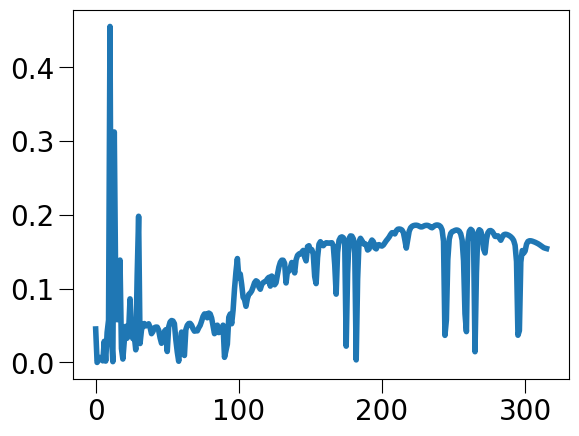

In [45]:
# diff_en = np.abs((energy_array - energy_array[1])/energy_array[1])
# plt.plot(diff_en)

Starting Position Animation: 500_InitialPos_100.gif 
Position Animation Saved: 500_InitialPos_100.gif


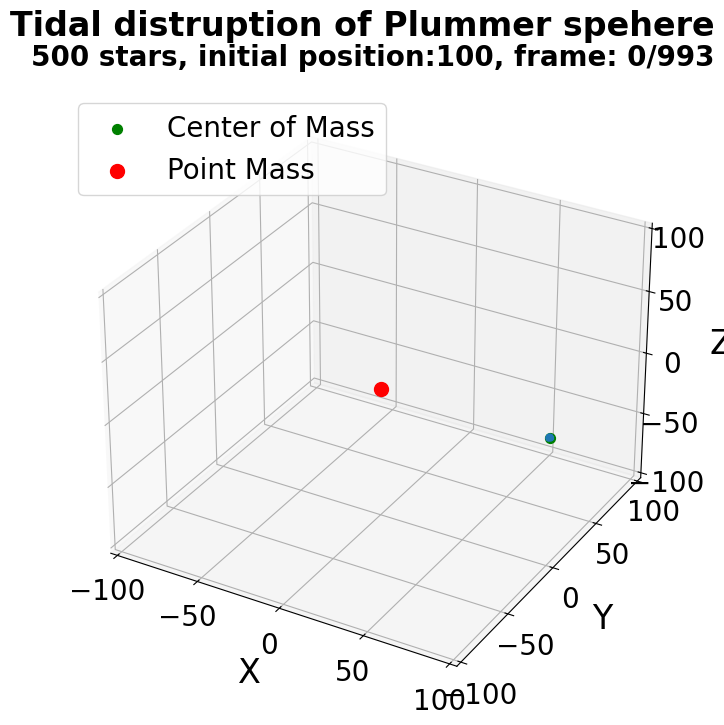

In [60]:
### downsampling
m = 1

pos_array_plot = pos_array.copy()[::m] #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)
pos_com_array_plot = pos_com_array.copy()[::m]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, 2),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])

indexes = np.arange(0, len(frames), 1)


ax.scatter(pos_array_plot[0][:, 0],pos_array_plot[0][:, 1], pos_array_plot[0][:, 2], s=5)
ax.scatter(pos_com_array_plot[0, 0], pos_com_array_plot[0, 1], pos_com_array_plot[0, 2], s=50, c='g', label='Center of Mass')
ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r', label='Point Mass')
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_zlim(-initial_position, initial_position)
ax.set_title(f'{N} stars, initial position:{initial_position}')
ax.legend(loc='upper left')


def update_pos(frame): 
    ax.clear()
    
    ax.scatter(pos_array_plot[frame][:, 0],pos_array_plot[frame][:, 1], pos_array_plot[frame][:, 2], s=5)
    ax.scatter(pos_com_array_plot[frame, 0], pos_com_array_plot[frame, 1], pos_com_array_plot[frame, 2], s=50, c='g', label='Center of Mass')
    ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r', label='Point Mass')
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{N} stars, initial position:{initial_position}, frame: {frame}/{frames.max()}')
    ax.legend(loc='upper left')
    
    fig.suptitle(f'Tidal distruption of Plummer spehere', 
                 fontsize=24, fontweight='600')

print(f"Starting Position Animation: {N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Galaxy_FoR/{N}_InitialPos_{initial_position}_ecc_{eccentricity}.gif", writer="pillow")

print(f"Position Animation Saved: {N}_InitialPos_{initial_position}.gif")